## **1. Import Libraries**


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

print("Libraries imported.")

Libraries imported.


## **2. Load Dataset**



In [6]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Lab1_TK/household.csv', parse_dates=['date'])

# Set date index & sort
df = df.set_index('date').sort_index()

# Remove text columns if exist
df = df.drop(columns=['main','description'], errors='ignore')

# ===== RESAMPLE TO HOURLY DATA =====
# Aggregate values by hourly mean
df = df.resample('H').mean()

# Interpolate missing values created by resampling
df = df.interpolate()

df.head()


/tmp/ipython-input-4104588760.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1
date,,,,,,,,,,,,,,,,
2022-11-05 14:00:00,248.780000,2.301455,122.312727,127.066364,281.159455,0.885213,24.246364,23.728182,23.689091,27.495091,1011.909091,38.436364,0.081818,8.000000,29.606000,27.912000
2022-11-05 15:00:00,202.663333,2.062333,122.410000,136.873500,252.208500,0.802048,24.302000,23.765333,24.156667,27.498000,1010.666667,37.366667,2.912167,333.900000,29.721333,27.978333
2022-11-05 16:00:00,198.863333,1.933833,122.725000,116.217833,234.804833,0.811255,24.174000,23.605833,24.002500,27.184000,1011.416667,36.666667,2.322667,326.750000,29.847667,28.139333
2022-11-05 17:00:00,390.181667,3.656500,122.185000,202.436167,445.381500,0.846390,23.485667,22.830667,23.046500,25.496167,1010.600000,36.083333,2.455000,302.833333,27.960167,26.480667
2022-11-05 18:00:00,443.036667,3.839500,121.908333,143.828000,467.515167,0.946220,21.693667,20.933333,21.497667,21.934500,1008.816667,38.783333,2.269500,267.316667,26.836500,26.228167


## **3. Feature Engineering**


In [7]:
data = df.copy()

# Lag features
data['ap_lag_1h'] = data['active_power'].shift(1)
data['ap_lag_24h'] = data['active_power'].shift(24)
data['ap_roll_24h'] = data['active_power'].rolling(24).mean()

# Time features
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = (data['weekday'] >= 5).astype(int)

# Keep only useful columns
keep = [
    'active_power','ap_lag_1h','ap_lag_24h','ap_roll_24h',
    'temp','feels_like','humidity','pressure','speed',
    'current','voltage','apparent_power','hour','weekday','is_weekend'
]
keep = [c for c in keep if c in data.columns]

data = data[keep].dropna().copy()

print("After feature engineering shape:", data.shape)
data

After feature engineering shape: (10210, 15)


,active_power,ap_lag_1h,ap_lag_24h,ap_roll_24h,temp,feels_like,humidity,pressure,speed,current,voltage,apparent_power,hour,weekday,is_weekend
date,,,,,,,,,,,,,,,
2022-11-06 14:00:00,163.376667,224.355000,248.780000,273.720891,28.653167,27.250167,21.083333,1013.916667,3.781167,1.701333,122.801667,208.594833,14,6,1
2022-11-06 15:00:00,297.003333,163.376667,202.663333,277.651724,28.226667,26.947833,21.516667,1013.016667,4.559333,2.743833,122.213333,333.192167,15,6,1
2022-11-06 16:00:00,396.440000,297.003333,198.863333,285.884085,27.816167,26.716833,22.916667,1013.250000,4.938667,3.489667,122.251667,426.028167,16,6,1
2022-11-06 17:00:00,311.295000,396.440000,390.181667,282.597141,25.777500,25.265667,24.566667,1013.166667,4.757667,2.855333,122.973333,350.784500,17,6,1
2022-11-06 18:00:00,443.610000,311.295000,443.036667,282.621030,23.328667,22.383333,25.483333,1011.133333,4.779167,4.006667,122.463333,487.643667,18,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05 19:00:00,329.995556,235.570833,293.395455,241.304597,13.546889,12.099556,43.733333,1013.733333,2.396889,3.069556,128.915556,395.692667,19,4,0
2024-01-05 20:00:00,393.211864,329.995556,342.735593,243.407775,11.364576,9.752203,45.779661,1012.559322,0.279322,3.386610,128.611864,433.508814,20,4,0
2024-01-05 21:00:00,233.649153,393.211864,396.593220,236.618439,10.550508,8.994915,51.067797,1014.288136,0.151525,2.048814,129.681356,265.509492,21,4,0


## **4. Train-Validate-Test Split (Time-based)**


In [8]:
TARGET = 'active_power'

X = data.drop(columns=[TARGET])
y = data[TARGET]

train_end = int(len(X) * 0.85)
val_end = int(len(X) * 0.95)
X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

print("Train shape:", X_train.shape)
print("Validate shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (8678, 14)
Validate shape: (1021, 14)
Test shape: (511, 14)


## **5. Scaling**



In [9]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

print("Scaling completed.")

Scaling completed.


## **6. Train Model using GridSearchCV + TimeSeriesSplit**



In [10]:
model = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [5, 8, None],
    'min_samples_leaf': [1, 2, 4]
}

tscv = TimeSeriesSplit(n_splits=5)

gscv = GridSearchCV(model, param_grid,
                    scoring='neg_mean_absolute_error',
                    cv=tscv, n_jobs=-1)

gscv.fit(X_train_s, y_train)

best = gscv.best_estimator_
print("Best parameters:", gscv.best_params_)

Best parameters: {'max_depth': 8, 'min_samples_leaf': 4}


## **7. Evaluate Model Performance**



In [11]:
y_pred = best.predict(X_test_s)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

MAE : 11.949476557431444
RMSE: 15.601126973512889
R²  : 0.9776789906352272


## **8. Feature Importance**



In [12]:
importances = pd.Series(best.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(10)

,0
apparent_power,0.996949
hour,0.000741
current,0.000681
ap_roll_24h,0.000672
ap_lag_1h,0.000183
pressure,0.000176
voltage,0.000156
speed,0.000098
feels_like,0.000093
humidity,0.000093


## **9. Visualization — Actual vs Predicted (Sample)**


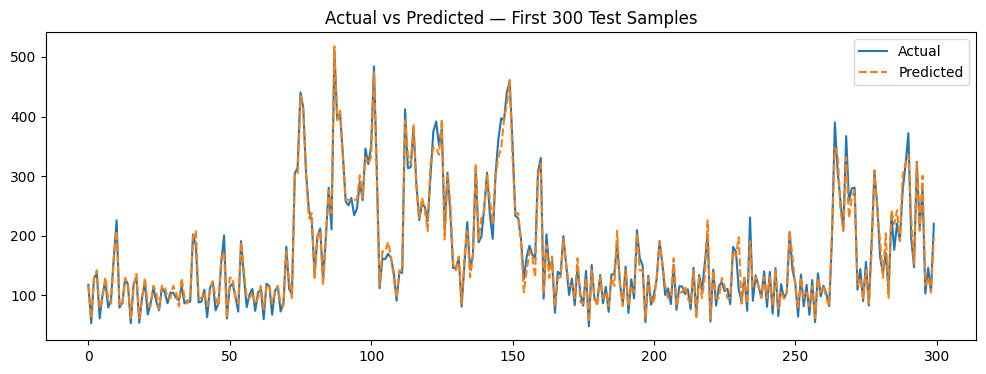

In [13]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:300], label="Actual")
plt.plot(y_pred[:300], label="Predicted", linestyle="--")
plt.legend()
plt.title("Actual vs Predicted — First 300 Test Samples")
plt.show()